# Business Understanding

# Data Understanding

# Data Preparation

In [1]:
import pandas as pd

In [2]:
patients = pd.read_csv('data/hospital-inpatient-discharges-sparcs-de-identified-2010-1.csv')

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3145: DtypeWarning: Columns (1,2,7,11,29) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [3]:
patients.head()

,index,Health Service Area,Hospital County,Operating Certificate Number,Facility ID,Facility Name,Age Group,Zip Code - 3 digits,Gender,Race,...,Source of Payment 2,Source of Payment 3,Attending Provider License Number,Operating Provider License Number,Other Provider License Number,Birth Weight,Abortion Edit Indicator,Emergency Department Indicator,Total Charges,Total Costs
0,0,Capital/Adiron,Albany,101000.0,1.0,Albany Medical Center Hospital,18 to 29,NaN,F,White,...,Self-Pay,NaN,3623.0,NaN,NaN,0,N,Y,4476.23,1672.65
1,1,Capital/Adiron,Albany,101000.0,1.0,Albany Medical Center Hospital,50 to 69,NaN,M,White,...,Medicare,Blue Cross,216951.0,216951.0,NaN,0,N,Y,148612.34,51414.70
2,2,Capital/Adiron,Albany,101000.0,1.0,Albany Medical Center Hospital,70 or Older,NaN,M,White,...,Blue Cross,Self-Pay,3076.0,NaN,NaN,0,N,N,16561.99,4032.49
3,3,Capital/Adiron,Albany,101000.0,1.0,Albany Medical Center Hospital,70 or Older,NaN,F,White,...,Insurance Company,Self-Pay,140796.0,140796.0,170254.0,0,N,N,13593.51,4947.81
4,4,Capital/Adiron,Albany,101000.0,1.0,Albany Medical Center Hospital,70 or Older,NaN,F,White,...,Insurance Company,Self-Pay,170254.0,170254.0,170254.0,0,N,N,31962.58,16988.33


In [4]:
patients = patients[patients['Hospital County']=='Kings']

In [5]:
patients.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 298247 entries, 1540091 to 2478653
Data columns (total 38 columns):
 #   Column                               Non-Null Count   Dtype  
---  ------                               --------------   -----  
 0   index                                298247 non-null  int64  
 1   Health Service Area                  298247 non-null  object 
 2   Hospital County                      298247 non-null  object 
 3   Operating Certificate Number         298247 non-null  float64
 4   Facility ID                          298247 non-null  float64
 5   Facility Name                        298247 non-null  object 
 6   Age Group                            298247 non-null  object 
 7   Zip Code - 3 digits                  298200 non-null  object 
 8   Gender                               298247 non-null  object 
 9   Race                                 298247 non-null  object 
 10  Ethnicity                            298247 non-null  object 
 11  Length

In [6]:
patients.isna().sum()

index                                       0
Health Service Area                         0
Hospital County                             0
Operating Certificate Number                0
Facility ID                                 0
Facility Name                               0
Age Group                                   0
Zip Code - 3 digits                        47
Gender                                      0
Race                                        0
Ethnicity                                   0
Length of Stay                              0
Type of Admission                           0
Patient Disposition                         6
Discharge Year                              0
CCS Diagnosis Code                         62
CCS Diagnosis Description                  62
CCS Procedure Code                         62
CCS Procedure Description                  62
APR DRG Code                                0
APR DRG Description                         0
APR MDC Code                      

In [7]:
patients.drop(columns=['index', 'Source of Payment 2', 'Source of Payment 3', 'Operating Provider License Number', 
                      'Other Provider License Number', 'Operating Certificate Number', 'Facility ID', 
                      'CCS Diagnosis Code', 'CCS Procedure Code', 'APR DRG Code', 'APR MDC Code', 
                       'APR Severity of Illness Code', 'Attending Provider License Number','Discharge Year',
                      'Birth Weight','Abortion Edit Indicator', 'Hospital County'], inplace=True)

In [8]:
patients.isna().sum()

Health Service Area                      0
Facility Name                            0
Age Group                                0
Zip Code - 3 digits                     47
Gender                                   0
Race                                     0
Ethnicity                                0
Length of Stay                           0
Type of Admission                        0
Patient Disposition                      6
CCS Diagnosis Description               62
CCS Procedure Description               62
APR DRG Description                      0
APR MDC Description                      0
APR Severity of Illness Description    134
APR Risk of Mortality                  134
APR Medical Surgical Description         0
Source of Payment 1                      0
Emergency Department Indicator           0
Total Charges                            0
Total Costs                              0
dtype: int64

In [9]:
patients = patients.dropna(how='any',axis=0)

In [10]:
patients.isna().sum()

Health Service Area                    0
Facility Name                          0
Age Group                              0
Zip Code - 3 digits                    0
Gender                                 0
Race                                   0
Ethnicity                              0
Length of Stay                         0
Type of Admission                      0
Patient Disposition                    0
CCS Diagnosis Description              0
CCS Procedure Description              0
APR DRG Description                    0
APR MDC Description                    0
APR Severity of Illness Description    0
APR Risk of Mortality                  0
APR Medical Surgical Description       0
Source of Payment 1                    0
Emergency Department Indicator         0
Total Charges                          0
Total Costs                            0
dtype: int64

In [11]:
names = []
for name in patients.columns:    
    name = name.replace(' ', '_')
    name = name.lower()
    names.append(name)
patients.columns = names

In [12]:
patients.columns

Index(['health_service_area', 'facility_name', 'age_group',
       'zip_code_-_3_digits', 'gender', 'race', 'ethnicity', 'length_of_stay',
       'type_of_admission', 'patient_disposition', 'ccs_diagnosis_description',
       'ccs_procedure_description', 'apr_drg_description',
       'apr_mdc_description', 'apr_severity_of_illness_description',
       'apr_risk_of_mortality', 'apr_medical_surgical_description',
       'source_of_payment_1', 'emergency_department_indicator',
       'total_charges', 'total_costs'],
      dtype='object')

In [13]:
patients.head()

,health_service_area,facility_name,age_group,zip_code_-_3_digits,gender,race,ethnicity,length_of_stay,type_of_admission,patient_disposition,...,ccs_procedure_description,apr_drg_description,apr_mdc_description,apr_severity_of_illness_description,apr_risk_of_mortality,apr_medical_surgical_description,source_of_payment_1,emergency_department_indicator,total_charges,total_costs
1540091,New York City,Brookdale Hospital Medical Center,0 to 17,100,M,White,Spanish/Hispanic,12,Newborn,Home or Self Care,...,NO PROC,"NEONATE BIRTHWT >2499G, NORMAL NEWBORN OR NEON...",Newborns and Other Neonates with Conditions Or...,Minor,Minor,Medical,Insurance Company,N,17611.10,9305.60
1540092,New York City,Brookdale Hospital Medical Center,0 to 17,100,M,Black/African American,Not Span/Hispanic,2,Emergency,Home or Self Care,...,"TRTMNT,FACE FRACT/DISLC",DENTAL & ORAL DISEASES & INJURIES,"Ear, Nose, Mouth, Throat and Craniofacial Dise...",Minor,Minor,Medical,CHAMPUS,Y,12429.82,8025.98
1540093,New York City,Brookdale Hospital Medical Center,0 to 17,100,M,Black/African American,Not Span/Hispanic,11,Newborn,Home or Self Care,...,OTHER THERAPEUTIC PRCS,NEONATE BIRTHWT >2499G W CONGENITAL/PERINATAL ...,Newborns and Other Neonates with Conditions Or...,Moderate,Minor,Medical,Insurance Company,N,20759.16,11015.50
1540094,New York City,Brookdale Hospital Medical Center,0 to 17,100,F,Black/African American,Spanish/Hispanic,34,Newborn,Home w/ Home Health Services,...,OTHER THERAPEUTIC PRCS,NEONATE BIRTHWT 1500-1999G W CONGENITAL/PERINA...,Newborns and Other Neonates with Conditions Or...,Moderate,Moderate,Medical,Medicaid,N,62600.46,33468.42
1540095,New York City,Brookdale Hospital Medical Center,0 to 17,100,F,Black/African American,Not Span/Hispanic,13,Emergency,Home or Self Care,...,PSYCHO/PSYCHI EVAL/THER,BIPOLAR DISORDERS,Mental Diseases and Disorders,Moderate,Minor,Medical,Medicaid,Y,24109.50,12666.76


In [14]:
patients['zip_code_-_3_digits'] = patients['zip_code_-_3_digits'].astype(str)
patients['zip_code_-_3_digits'] = patients['zip_code_-_3_digits'].apply(lambda x: x[:3])
patients['zip_code'] = patients['zip_code_-_3_digits']
patients.drop(columns=['zip_code_-_3_digits'],inplace=True)

In [15]:
patients.head()

,health_service_area,facility_name,age_group,gender,race,ethnicity,length_of_stay,type_of_admission,patient_disposition,ccs_diagnosis_description,...,apr_drg_description,apr_mdc_description,apr_severity_of_illness_description,apr_risk_of_mortality,apr_medical_surgical_description,source_of_payment_1,emergency_department_indicator,total_charges,total_costs,zip_code
1540091,New York City,Brookdale Hospital Medical Center,0 to 17,M,White,Spanish/Hispanic,12,Newborn,Home or Self Care,LIVEBORN,...,"NEONATE BIRTHWT >2499G, NORMAL NEWBORN OR NEON...",Newborns and Other Neonates with Conditions Or...,Minor,Minor,Medical,Insurance Company,N,17611.10,9305.60,100
1540092,New York City,Brookdale Hospital Medical Center,0 to 17,M,Black/African American,Not Span/Hispanic,2,Emergency,Home or Self Care,SKULL/FACE FRACTURE,...,DENTAL & ORAL DISEASES & INJURIES,"Ear, Nose, Mouth, Throat and Craniofacial Dise...",Minor,Minor,Medical,CHAMPUS,Y,12429.82,8025.98,100
1540093,New York City,Brookdale Hospital Medical Center,0 to 17,M,Black/African American,Not Span/Hispanic,11,Newborn,Home or Self Care,LIVEBORN,...,NEONATE BIRTHWT >2499G W CONGENITAL/PERINATAL ...,Newborns and Other Neonates with Conditions Or...,Moderate,Minor,Medical,Insurance Company,N,20759.16,11015.50,100
1540094,New York City,Brookdale Hospital Medical Center,0 to 17,F,Black/African American,Spanish/Hispanic,34,Newborn,Home w/ Home Health Services,LIVEBORN,...,NEONATE BIRTHWT 1500-1999G W CONGENITAL/PERINA...,Newborns and Other Neonates with Conditions Or...,Moderate,Moderate,Medical,Medicaid,N,62600.46,33468.42,100
1540095,New York City,Brookdale Hospital Medical Center,0 to 17,F,Black/African American,Not Span/Hispanic,13,Emergency,Home or Self Care,MOOD DISORDERS,...,BIPOLAR DISORDERS,Mental Diseases and Disorders,Moderate,Minor,Medical,Medicaid,Y,24109.50,12666.76,100


In [16]:
patients['gender'] = patients['gender'].apply(lambda x: 'F' if x == 'U' else x)

In [17]:
patients['race'] = patients['race'].apply(lambda x: 'White' if x == 'Unknown' else x)

In [18]:
patients['type_of_admission'] = patients['type_of_admission'].apply(lambda x: 'Emergency' if x == 'Not Available' 
                                                                    else x)

In [19]:
patients.head()

,health_service_area,facility_name,age_group,gender,race,ethnicity,length_of_stay,type_of_admission,patient_disposition,ccs_diagnosis_description,...,apr_drg_description,apr_mdc_description,apr_severity_of_illness_description,apr_risk_of_mortality,apr_medical_surgical_description,source_of_payment_1,emergency_department_indicator,total_charges,total_costs,zip_code
1540091,New York City,Brookdale Hospital Medical Center,0 to 17,M,White,Spanish/Hispanic,12,Newborn,Home or Self Care,LIVEBORN,...,"NEONATE BIRTHWT >2499G, NORMAL NEWBORN OR NEON...",Newborns and Other Neonates with Conditions Or...,Minor,Minor,Medical,Insurance Company,N,17611.10,9305.60,100
1540092,New York City,Brookdale Hospital Medical Center,0 to 17,M,Black/African American,Not Span/Hispanic,2,Emergency,Home or Self Care,SKULL/FACE FRACTURE,...,DENTAL & ORAL DISEASES & INJURIES,"Ear, Nose, Mouth, Throat and Craniofacial Dise...",Minor,Minor,Medical,CHAMPUS,Y,12429.82,8025.98,100
1540093,New York City,Brookdale Hospital Medical Center,0 to 17,M,Black/African American,Not Span/Hispanic,11,Newborn,Home or Self Care,LIVEBORN,...,NEONATE BIRTHWT >2499G W CONGENITAL/PERINATAL ...,Newborns and Other Neonates with Conditions Or...,Moderate,Minor,Medical,Insurance Company,N,20759.16,11015.50,100
1540094,New York City,Brookdale Hospital Medical Center,0 to 17,F,Black/African American,Spanish/Hispanic,34,Newborn,Home w/ Home Health Services,LIVEBORN,...,NEONATE BIRTHWT 1500-1999G W CONGENITAL/PERINA...,Newborns and Other Neonates with Conditions Or...,Moderate,Moderate,Medical,Medicaid,N,62600.46,33468.42,100
1540095,New York City,Brookdale Hospital Medical Center,0 to 17,F,Black/African American,Not Span/Hispanic,13,Emergency,Home or Self Care,MOOD DISORDERS,...,BIPOLAR DISORDERS,Mental Diseases and Disorders,Moderate,Minor,Medical,Medicaid,Y,24109.50,12666.76,100


In [20]:
patients['source_of_payment_1'] = patients['source_of_payment_1'].apply(lambda x: 'Medicare' if x == 'Unknown' 
                                                              else x)

In [21]:
patients.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 297998 entries, 1540091 to 2478653
Data columns (total 21 columns):
 #   Column                               Non-Null Count   Dtype  
---  ------                               --------------   -----  
 0   health_service_area                  297998 non-null  object 
 1   facility_name                        297998 non-null  object 
 2   age_group                            297998 non-null  object 
 3   gender                               297998 non-null  object 
 4   race                                 297998 non-null  object 
 5   ethnicity                            297998 non-null  object 
 6   length_of_stay                       297998 non-null  object 
 7   type_of_admission                    297998 non-null  object 
 8   patient_disposition                  297998 non-null  object 
 9   ccs_diagnosis_description            297998 non-null  object 
 10  ccs_procedure_description            297998 non-null  object 
 11  apr_dr

In [22]:
patients['length_of_stay'] = patients['length_of_stay'].apply(lambda x: '120' if x == '120 +' else x)

In [23]:
patients['length_of_stay'] = patients['length_of_stay'].astype(int)

In [24]:
patients.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 297998 entries, 1540091 to 2478653
Data columns (total 21 columns):
 #   Column                               Non-Null Count   Dtype  
---  ------                               --------------   -----  
 0   health_service_area                  297998 non-null  object 
 1   facility_name                        297998 non-null  object 
 2   age_group                            297998 non-null  object 
 3   gender                               297998 non-null  object 
 4   race                                 297998 non-null  object 
 5   ethnicity                            297998 non-null  object 
 6   length_of_stay                       297998 non-null  int64  
 7   type_of_admission                    297998 non-null  object 
 8   patient_disposition                  297998 non-null  object 
 9   ccs_diagnosis_description            297998 non-null  object 
 10  ccs_procedure_description            297998 non-null  object 
 11  apr_dr

# Exploratory Data Analysis

In [25]:
patients.drop(columns = ['ethnicity', 'emergency_department_indicator', 'zip_code',
                         'apr_medical_surgical_description','apr_mdc_description'],inplace=True)

In [26]:
patients.drop(columns = ['apr_risk_of_mortality'],inplace=True)
patients.drop(columns = ['source_of_payment_1'],inplace=True)


In [27]:
patients.reset_index(inplace=True,drop=True)

In [28]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder

In [29]:
categorical_columns = patients.select_dtypes(include=['object']).columns.tolist()

In [30]:
encoder = OneHotEncoder(sparse=False,drop='first')

# Apply one-hot encoding to the categorical columns
one_hot_encoded = encoder.fit_transform(patients[categorical_columns])

#Create a DataFrame with the one-hot encoded columns
#We use get_feature_names_out() to get the column names for the encoded data
one_hot_df = pd.DataFrame(one_hot_encoded, columns=encoder.get_feature_names(categorical_columns))

In [31]:
one_hot_df

,facility_name_Brookdale Hospital Medical Center,facility_name_Brooklyn Hospital Center - Downtown Campus,facility_name_Coney Island Hospital,facility_name_Interfaith Medical Center,facility_name_Kings County Hospital Center,facility_name_Kingsbrook Jewish Medical Center,facility_name_Lutheran Medical Center,facility_name_Maimonides Medical Center,"facility_name_New York Community Hospital of Brooklyn, Inc",facility_name_New York Methodist Hospital,...,apr_drg_description_VAGINAL DELIVERY,apr_drg_description_VAGINAL DELIVERY W COMPLICATING PROCEDURES EXC STERILIZATION &/OR D&C,apr_drg_description_VAGINAL DELIVERY W STERILIZATION &/OR D&C,apr_drg_description_VENTRICULAR SHUNT PROCEDURES,apr_drg_description_VERTIGO & OTHER LABYRINTH DISORDERS,apr_drg_description_VIRAL ILLNESS,apr_drg_description_VIRAL MENINGITIS,apr_severity_of_illness_description_Major,apr_severity_of_illness_description_Minor,apr_severity_of_illness_description_Moderate
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
297993,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
297994,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
297995,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
297996,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [32]:
num_col = patients[['total_charges', 'total_costs']]

In [33]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaled_data = scaler.fit_transform(num_col)
scaled_df = pd.DataFrame(scaled_data,
                         columns=num_col.columns)

In [34]:
scaled_df

,total_charges,total_costs
0,-0.163522,-0.112664
1,-0.274045,-0.167807
2,-0.096371,-0.038980
3,0.796150,0.928585
4,-0.024904,0.032178
...,...,...
297993,-0.408681,-0.287467
297994,-0.331306,-0.153354
297995,0.224653,0.810285
297996,0.843712,1.883296


In [35]:
df_preproc = pd.concat([scaled_df, one_hot_df], axis=1)

In [36]:
y = patients[['length_of_stay']]
X = df_preproc

In [37]:
import statsmodels.api as sm

baseline_model = sm.OLS(y, sm.add_constant(X))
baseline_results = baseline_model.fit()

In [38]:
print(baseline_results.summary())

                            OLS Regression Results                            
Dep. Variable:         length_of_stay   R-squared:                       0.742
Model:                            OLS   Adj. R-squared:                  0.741
Method:                 Least Squares   F-statistic:                     1020.
Date:                Mon, 27 Jan 2025   Prob (F-statistic):               0.00
Time:                        17:07:07   Log-Likelihood:            -8.6225e+05
No. Observations:              297998   AIC:                         1.726e+06
Df Residuals:                  297161   BIC:                         1.735e+06
Df Model:                         836                                         
Covariance Type:            nonrobust                                         
                                                                                                                    coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------

# Model

Text(0, 0.5, 'cumulative explained variance')

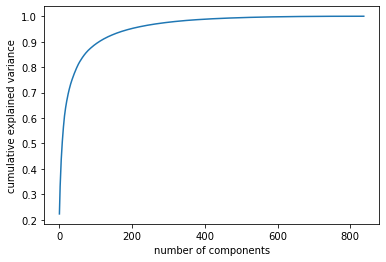

In [39]:
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt
import numpy as np

pca = PCA().fit(df_preproc)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')

In [55]:
X = patients.drop(columns = ['length_of_stay'], axis=1)
y = patients[['length_of_stay']]

In [56]:
X

,health_service_area,facility_name,age_group,gender,race,type_of_admission,patient_disposition,ccs_diagnosis_description,ccs_procedure_description,apr_drg_description,apr_severity_of_illness_description,total_charges,total_costs
0,New York City,Brookdale Hospital Medical Center,0 to 17,M,White,Newborn,Home or Self Care,LIVEBORN,NO PROC,"NEONATE BIRTHWT >2499G, NORMAL NEWBORN OR NEON...",Minor,17611.10,9305.60
1,New York City,Brookdale Hospital Medical Center,0 to 17,M,Black/African American,Emergency,Home or Self Care,SKULL/FACE FRACTURE,"TRTMNT,FACE FRACT/DISLC",DENTAL & ORAL DISEASES & INJURIES,Minor,12429.82,8025.98
2,New York City,Brookdale Hospital Medical Center,0 to 17,M,Black/African American,Newborn,Home or Self Care,LIVEBORN,OTHER THERAPEUTIC PRCS,NEONATE BIRTHWT >2499G W CONGENITAL/PERINATAL ...,Moderate,20759.16,11015.50
3,New York City,Brookdale Hospital Medical Center,0 to 17,F,Black/African American,Newborn,Home w/ Home Health Services,LIVEBORN,OTHER THERAPEUTIC PRCS,NEONATE BIRTHWT 1500-1999G W CONGENITAL/PERINA...,Moderate,62600.46,33468.42
4,New York City,Brookdale Hospital Medical Center,0 to 17,F,Black/African American,Emergency,Home or Self Care,MOOD DISORDERS,PSYCHO/PSYCHI EVAL/THER,BIPOLAR DISORDERS,Moderate,24109.50,12666.76
...,...,...,...,...,...,...,...,...,...,...,...,...,...
297993,New York City,Woodhull Medical & Mental Health Center,70 or Older,M,White,Emergency,Home or Self Care,SYNCOPE,DX ULTRASOUND HEART,SYNCOPE & COLLAPSE,Minor,6118.08,5249.20
297994,New York City,Woodhull Medical & Mental Health Center,70 or Older,M,Black/African American,Emergency,Home or Self Care,DYSRHYTHMIA,CARDIAC STRESS TESTS,CARDIAC ARRHYTHMIA & CONDUCTION DISORDERS,Major,9745.40,8361.37
297995,New York City,Woodhull Medical & Mental Health Center,70 or Older,M,Other Race,Emergency,Skilled Nursing Home,ACUTE RENAL FAILURE,NO PROC,RENAL FAILURE,Major,35808.71,30723.19
297996,New York City,Woodhull Medical & Mental Health Center,70 or Older,F,White,Emergency,Inpatient Rehabilitation Facility,DYSRHYTHMIA,BLOOD TRANSFUSION,CARDIAC ARRHYTHMIA & CONDUCTION DISORDERS,Extreme,64830.18,55623.06


In [57]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


In [58]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)

In [59]:
#Showing that each dataset split possesses similar percentage of y values. 
print("Train percent:", y_train.value_counts(normalize=True)[1])
print("Valid percent: ", y_valid.value_counts(normalize=True)[1])
print("Hold percent: ", y_test.value_counts(normalize=True)[1])

Train percent: length_of_stay
1                 0.145498
dtype: float64
Valid percent:  length_of_stay
1                 0.145512
dtype: float64
Hold percent:  length_of_stay
1                 0.145503
dtype: float64


In [60]:
len(X_train)

190718

In [61]:
len(X_valid)

47680

In [62]:
len(X_test)

59600

In [63]:
#Creating a metrics function that will be reused for all of our modeling. It will contain the two metrics I am most
#focused on: recall and f1. 
def metrics_cv(cross_val_r2, cross_val_rmse, model_type, data):
    
    '''
    The function will take in two cross validation scores. One for recall and one for f1. It will then print out
    the mean score for the train and test sets from the cross validation folds. Additionally, it will take in the 
    model type used (logistic regression), and which dataset it is being performed on (train, valid).
    '''
    
    print(f"{model_type} {data} cross validation scores:")
    print('\n')
    print("r2 scores - ")
    print(f"Average Train Score: {np.mean(cross_val_r2['train_score'])}")
    print(f"Average Test Score: {np.mean(cross_val_r2['test_score'])}")
    print('\n')
    print('rmse scores -')
    print(f"Average Train Score: {np.mean(cross_val_rmse['train_score'])}")
    print(f"Average Test Score: {np.mean(cross_val_rmse['test_score'])}")
    
#*4: Citation
#*5: Citation
#*6: Citation

In [64]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression

In [65]:
cat_cols = []

for col in patients.columns:
    if patients[col].dtype == 'O':
        cat_cols.append(col)
        
cat_cols

['health_service_area',
 'facility_name',
 'age_group',
 'gender',
 'race',
 'type_of_admission',
 'patient_disposition',
 'ccs_diagnosis_description',
 'ccs_procedure_description',
 'apr_drg_description',
 'apr_severity_of_illness_description']

In [66]:
num_cols = []

for col in patients.columns:
    if patients[col].dtype == 'float64':
        num_cols.append(col)
        
num_cols

['total_charges', 'total_costs']

In [74]:
preprocessor = ColumnTransformer(
    transformers=[
        ('scaled', StandardScaler(), num_cols),
        ('ohe', OneHotEncoder(sparse=False,handle_unknown='ignore'), cat_cols)
    ])

In [75]:
my_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('pca', PCA(n_components= 275)),
                              ('model', LinearRegression())
                             ])

In [76]:
my_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('scaled', StandardScaler(),
                                                  ['total_charges',
                                                   'total_costs']),
                                                 ('ohe',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  ['health_service_area',
                                                   'facility_name', 'age_group',
                                                   'gender', 'race',
                                                   'type_of_admission',
                                                   'patient_disposition',
                                                   'ccs_diagnosis_description',
                                                   'ccs_procedure_description'

In [77]:
from sklearn.model_selection import cross_validate
import numpy as np

baseline_linreg_r2 = cross_validate(my_pipeline, X_train, y_train, scoring="r2", return_train_score=True)
baseline_linreg_rmse = cross_validate(my_pipeline, X_train, y_train, scoring="neg_root_mean_squared_error", return_train_score=True)

In [78]:
metrics_cv(baseline_linreg_r2,baseline_linreg_rmse, 'Linear Regression', 'X_train')

Linear Regression X_train cross validation scores:


r2 scores - 
Average Train Score: 0.7223075460425867
Average Test Score: 0.7118067523910943


rmse scores -
Average Train Score: -4.526286084395627
Average Test Score: -4.591834146123376


# Evaluation

# Conclusion

## Recommendations

## Next Steps